In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from module import MlfcsTrainer
import metrics

In [2]:
dat = pd.read_pickle('../dat/training_set.pk')

In [3]:
def create_activation_array(K, activation='heaviside', threshold=0.5, scale=1.0, min_proportion=0.0, noise_level=0.0):
    """
    Creates a mirrored numpy array of size K based on an activation function, with a specified minimum value proportion
    and optional noise.

    Parameters:
        K (int): The size of the array.
        activation (str): The activation function to use. Options are 'heaviside', 'sigmoid', 'tanh', 'relu'.
        threshold (float): Proportion threshold for activation, between 0 and 1.
        scale (float): Scaling factor to control the range of the activation function values.
        min_proportion (float): Minimum value as a proportion of the scale.
        noise_level (float): The standard deviation of the noise to add, as a fraction of the scale.

    Returns:
        np.ndarray: Array of size K with mirrored activation function, minimum value at the given proportion, and noise.
    """
    # Generate an array of values from 0 to 1 for K elements
    x = np.linspace(0, 1, K)
    threshold_index = K - int(K * threshold)

    # Define the activation function based on user choice
    if activation == 'heaviside':
        f_x = np.heaviside(x - x[threshold_index], 0.5)
    elif activation == 'sigmoid':
        f_x = 1 / (1 + np.exp(-10 * (x - x[threshold_index])))
    elif activation == 'tanh':
        f_x = np.tanh(10 * (x - x[threshold_index]))
    elif activation == 'relu':
        f_x = np.maximum(0, x - x[threshold_index])
    else:
        raise ValueError("Unsupported activation function. Choose from 'heaviside', 'sigmoid', 'tanh', 'relu'.")

    # Mirror the function
    mirrored_f_x = np.flip(f_x)

    # Scale the array to have a specified minimum proportion of the scale
    min_value = min_proportion * scale
    mirrored_f_x = (mirrored_f_x - mirrored_f_x.min()) / (mirrored_f_x.max() - mirrored_f_x.min())  # Normalize to [0, 1]
    mirrored_f_x = mirrored_f_x * (scale - min_value) + min_value  # Scale to [min_value, scale]

    # Ensure values remain within [min_value, scale] after noise addition
    mirrored_f_x = np.clip(mirrored_f_x, min_value, scale)

    # Add noise
    noise = np.random.normal(0, noise_level * scale, K)  # Noise scaled by noise_level and scale
    mirrored_f_x += noise

    return mirrored_f_x




def plot_activation_functions(K, threshold=0.5, scale=1.0,min_proportion=0.0, noise_level=0.0):
    """
    Plots all mirrored activation functions on the same figure with the specified parameters.

    Parameters:
        K (int): The size of the array.
        threshold (float): Proportion threshold for activation, between 0 and 1.
        scale (float): Scaling factor to control the range of the activation function values.
    """
    activations = ['heaviside', 'sigmoid', 'tanh', 'relu']
    x = np.linspace(0, K, K)

    plt.figure(figsize=(10, 6))

    for activation in activations:
        y = create_activation_array(K, activation, threshold, scale,min_proportion, noise_level)
        plt.plot(x, y, label=f'{activation.capitalize()}')

    plt.title(f'Mirrored Activation Functions with threshold={threshold} and scale={scale}')
    plt.xlabel('Index')
    plt.ylabel('Activation Output')
    plt.legend()
    plt.grid(True)
    plt.show()



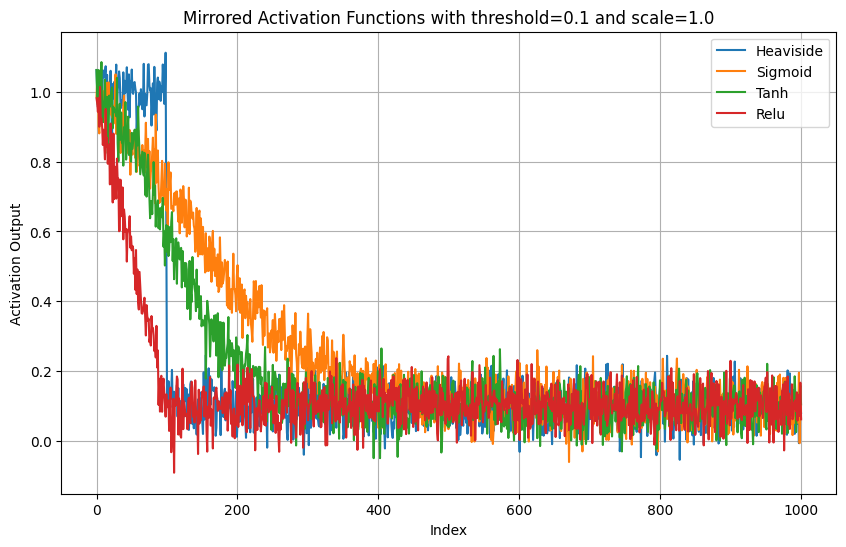

In [4]:
# Example usage
plot_activation_functions(1000, threshold=0.1, scale=1.0,min_proportion=0.1, noise_level=0.05)

In [5]:
def create_activation_data(K=1000):
    # Define the parameter ranges
    activation_types = ['heaviside', 'sigmoid', 'tanh', 'relu']
    thresholds = np.arange(0.1, 1.0, 0.1)
    scales = np.arange(0.1, 1.1, 0.1)
    min_proportions = np.arange(0, 0.31, 0.1)
    noise_levels = np.arange(0, 0.11, 0.02)
    omega_x_values = [200, 225, 250, 275, 300]
    omega_values = [500, 600, 700]
    time_list = [0.25, 0.5, 0.75, 1.0, 1.25 , 1.50, 2.0]

    # Initialize an empty list to store each row of the DataFrame
    rows = []

    # Iterate over all combinations of the parameters
    for activation_type in activation_types:
        for threshold in thresholds:
            for scale in scales:
                for min_proportion in min_proportions:
                    for noise_level in noise_levels:
                        # Generate the activation array
                        G = create_activation_array(K, activation=activation_type, threshold=threshold,
                                                    scale=scale, min_proportion=min_proportion,
                                                    noise_level=noise_level)
                        for omega_x in omega_x_values:
                            for omega in omega_values:
                                for t_max in time_list:
                                    # Append the row to the list
                                    rows.append({
                                        'G': G,
                                        'Time window': t_max,
                                        'omega_x': omega_x,
                                        'omega': omega,
                                        'activation_type': activation_type,
                                        'threshold': threshold,
                                        'scale': scale,
                                        'min_proportion': min_proportion,
                                        'noise_level': noise_level
                                    })

    # Convert the list of rows into a DataFrame
    df = pd.DataFrame(rows)
    return df

In [6]:
# Example usage
activation_df = create_activation_data()
activation_df.head()

,G,Time window,omega_x,omega,activation_type,threshold,scale,min_proportion,noise_level
0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.25,200,500,heaviside,0.1,0.1,0.0,0.0
1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.50,200,500,heaviside,0.1,0.1,0.0,0.0
2,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.75,200,500,heaviside,0.1,0.1,0.0,0.0
3,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1.00,200,500,heaviside,0.1,0.1,0.0,0.0
4,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1.25,200,500,heaviside,0.1,0.1,0.0,0.0


In [7]:
Module = joblib.load('../data/new_model_trained_4modelsDlast.pk')

In [8]:
activation_df = Module.predict_dataframe(activation_df)

In [9]:
#activation_df = pd.read_pickle('test_act_fn.pk')
activation_df.to_pickle('test_act_fn.pk')

In [10]:
activation_df.head()

,G,Time window,omega_x,omega,activation_type,threshold,scale,min_proportion,noise_level,alpha pred,D pred,Model pred,Proba CTRW,Proba FBM,Proba MB,Proba RWF
0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.25,200,500,heaviside,0.1,0.1,0.0,0.0,0.499445,-0.026574,RWF,0.011751,0.006066,0.000102,0.982081
1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.50,200,500,heaviside,0.1,0.1,0.0,0.0,0.499445,-0.043657,RWF,0.012754,0.006059,0.000102,0.981085
2,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.75,200,500,heaviside,0.1,0.1,0.0,0.0,0.499445,-0.043657,RWF,0.018106,0.006027,0.000101,0.975767
3,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1.00,200,500,heaviside,0.1,0.1,0.0,0.0,0.499445,-0.043657,RWF,0.022633,0.006879,0.000115,0.970373
4,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1.25,200,500,heaviside,0.1,0.1,0.0,0.0,0.499445,-0.043657,RWF,0.027708,0.006773,0.000102,0.965416


In [11]:
print(np.sum((activation_df['Model pred'] == 'CTRW')))
print(np.sum((activation_df['Model pred'] == 'MB')))
print(np.sum((activation_df['Model pred'] == 'FBM')))
print(np.sum((activation_df['Model pred'] == 'RWF')))

264994
77278
340642
224286


In [12]:
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
shap.initjs()

# Load data
df = pd.read_pickle('test_act_fn.pk')
df['activation_type'] = df['activation_type'].astype('category')
df['Model pred'] = df['Model pred'].astype('category')

# Prepare features and target
features = df[['activation_type', 'threshold', 'scale', 'min_proportion', 'noise_level']]
y = df['Model pred']
del df

# Encode the target variable if needed
if y.dtypes == 'object' or y.dtypes.name == 'category':
    y_encoder = LabelEncoder().fit(y)
    y = y_encoder.transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=1066)

# Encode categorical features as integers for HistGradientBoostingClassifier compatibility
categorical_features = ['activation_type']
for col in categorical_features:
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

# Train a HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=200, max_depth=10)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f'Model fitted with score {score}')

# Use SHAP TreeExplainer for SHAP analysis
explainer = shap.TreeExplainer(model, X_train)
print("Explainer start")


# Sample X_test for faster SHAP analysis
X_test_sample = X_test.sample(10000, random_state=42)

# Compute SHAP values with a progress bar
shap_values = explainer.shap_values(X_test_sample)


Model fitted with score 0.8914351851851852
Explainer start


100%|===================| 39920/40000 [08:15<00:00]        

ValueError: y should be a 1d array, got an array of shape () instead.

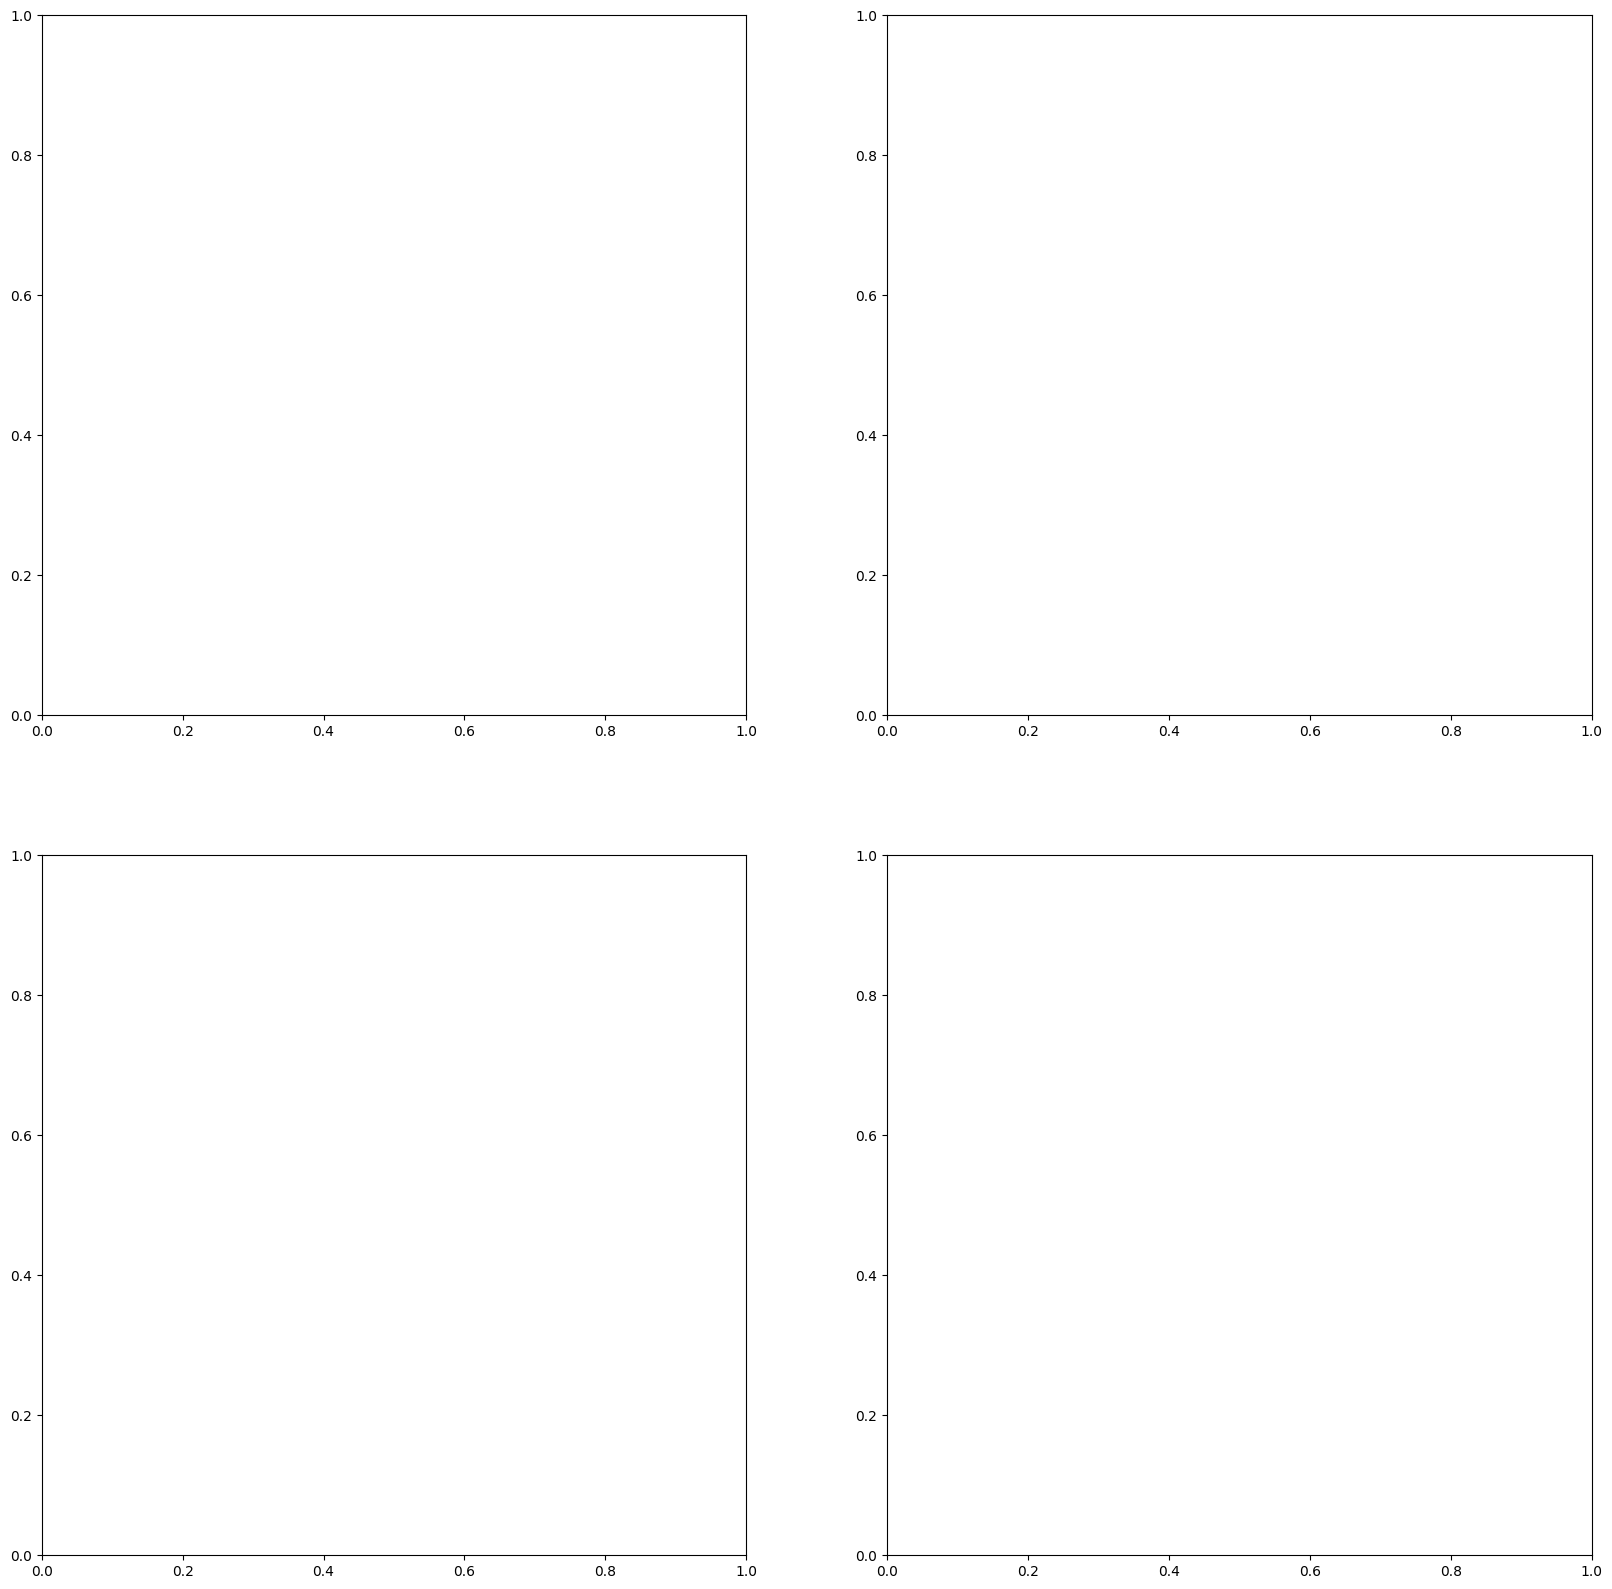

In [14]:
import shap
import matplotlib.pyplot as plt
from PIL import Image
import io

for class_model in range(4):
    # Select SHAP values for a specific class
    shap_values_for_class = shap_values[:, :, class_model]

    # Create a SHAP Explanation object for SHAP visualizations
    shap_explanation = shap.Explanation(
        values=shap_values_for_class,
        base_values=explainer.expected_value[class_model],
        data=X_test_sample,
        feature_names=X_test_sample.columns
    )

    # Save each SHAP plot to an image buffer
    images = []

    # 1. SHAP Beeswarm Plot
    buf = io.BytesIO()
    shap.plots.beeswarm(shap_explanation, show=False)
    plt.savefig(buf, format='png')
    images.append(Image.open(buf))
    plt.close()

    # 2. SHAP Bar Plot
    buf = io.BytesIO()
    shap.plots.bar(shap_explanation, show=False)
    plt.savefig(buf, format='png')
    images.append(Image.open(buf))
    plt.close()

    # 3. SHAP Dependence Plot for 'threshold'
    buf = io.BytesIO()
    shap.dependence_plot('threshold', shap_values_for_class, X_test_sample, show=False)
    plt.savefig(buf, format='png')
    images.append(Image.open(buf))
    plt.close()

    # 4. SHAP Dependence Plot for 'min_proportion'
    buf = io.BytesIO()
    shap.dependence_plot('min_proportion', shap_values_for_class, X_test_sample, show=False)
    plt.savefig(buf, format='png')
    images.append(Image.open(buf))
    plt.close()

    # Create a unified figure with the four images as subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f"SHAP Analysis for Class {y_encoder.inverse_transform(class_model)}", fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.axis('off')  # Hide axes for images

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


